# Class Challenge: Image Classification of COVID-19 X-rays
# Task 2 [Total points: 30]

## Setup

* This assignment involves the following packages: 'matplotlib', 'numpy', and 'sklearn'. 

* If you are using conda, use the following commands to install the above packages:<br>
```shell
conda install matplotlib
conda install numpy
conda install -c anaconda scikit-learn
```

* If you are using pip, use use the following commands to install the above packages: <br> 
```shell
pip install matplotlib
pip install numpy
pip install sklearn
```

## Data

Please download the data using the following link: [COVID-19](https://drive.google.com/file/d/1Y88tgqpQ1Pjko_7rntcPowOJs_QNOrJ-/view). 

* After downloading 'Covid_Data_GradientCrescent.zip', unzip the file and you should see the following data structure:


|--all<br>
|--------train<br>
|--------test<br>
|--two<br>
|--------train<br>
|--------test<br>


* Put the 'all' folder, the 'two' folder and this python notebook in the **same directory** so that the following code can correctly locate the data.  



## [20 points] Multi-class Classification

In [1]:
import os

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# os.environ['OMP_NUM_THREADS'] = '1'
# os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
tf.__version__

'2.1.0'

In [2]:
# # https://www.tensorflow.org/guide/gpu
# tf.debugging.set_log_device_placement(True)
# # Create some tensors
# a = tf.constant([[1.0, 2.0, 3.0], [4.0, 5.0, 6.0]])
# b = tf.constant([[1.0, 2.0], [3.0, 4.0], [5.0, 6.0]])
# c = tf.matmul(a, b)

# # https://stackoverflow.com/questions/38559755/how-to-get-current-available-gpus-in-tensorflow
# from tensorflow.python.client import device_lib

# def get_available_gpus():
#     local_device_protos = device_lib.list_local_devices()
#     return [x.name for x in local_device_protos if x.device_type == 'GPU']
# print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
# get_available_gpus()

#### Load Image Data

In [3]:
DATA_LIST = os.listdir('all/train')
DATASET_PATH  = 'all/train'
TEST_DIR =  'all/test'
IMAGE_SIZE    = (224, 224)
NUM_CLASSES   = len(DATA_LIST)
BATCH_SIZE    = 10  # try reducing batch size or freeze more layers if your GPU runs out of memory
NUM_EPOCHS    = 100
LEARNING_RATE = 0.0001 # start off with high rate first 0.001 and experiment with reducing it gradually 

#### Generate Training and Validation Batches

In [4]:
train_datagen = ImageDataGenerator(rescale=1./255,rotation_range=50,featurewise_center = True,
                                   featurewise_std_normalization = True,width_shift_range=0.2,
                                   height_shift_range=0.2,shear_range=0.25,zoom_range=0.1,
                                   zca_whitening = True,channel_shift_range = 20,
                                   horizontal_flip = True,vertical_flip = True,
                                   validation_split = 0.2,fill_mode='constant')


train_batches = train_datagen.flow_from_directory(DATASET_PATH,target_size=IMAGE_SIZE,
                                                  shuffle=True,batch_size=BATCH_SIZE,
                                                  subset = "training",seed=42,
                                                  class_mode="categorical")

valid_batches = train_datagen.flow_from_directory(DATASET_PATH,target_size=IMAGE_SIZE,
                                                  shuffle=True,batch_size=BATCH_SIZE,
                                                  subset = "validation",
                                                  seed=42,class_mode="categorical")

/opt/anaconda3/lib/python3.7/site-packages/keras_preprocessing/image/image_data_generator.py:341: UserWarning: This ImageDataGenerator specifies `zca_whitening` which overrides setting of`featurewise_std_normalization`.
  warnings.warn('This ImageDataGenerator specifies '


Found 216 images belonging to 4 classes.
Found 54 images belonging to 4 classes.


#### [10 points] Build Model
Hint: Starting from a pre-trained model typically helps performance on a new task, e.g. starting with weights obtained by training on ImageNet. 

In [1]:
from tensorflow.keras.applications import VGG16, VGG19, InceptionV3,InceptionResNetV2, DenseNet121
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout, AveragePooling2D
from tensorflow.keras import regularizers

#pretrained model with imagenet weights
vgg_16 =  VGG16(include_top=False,weights='imagenet',input_shape=(224,224,3))

#fine-tuning on the last conv2D layer
vgg_16.trainable = True
fine_tune = len(vgg_16.layers)-2
print(fine_tune)
for layer in vgg_16.layers[:fine_tune]:
    layer.trainable =  False

    
    
covid_model = Sequential()
covid_model.add(vgg_16)
#covid_model.add(Dropout(0.2))
covid_model.add(Flatten())
covid_model.add(Dropout(0.2))
covid_model.add(Dense(256,activation="relu",name="feature_dense"))
covid_model.add(Dropout(0.2))
covid_model.add(Dense(4,activation="softmax"))

covid_model.summary()

17
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
dropout (Dropout)            (None, 25088)             0         
_________________________________________________________________
feature_dense (Dense)        (None, 256)               6422784   
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense (Dense)                (None, 4)                 1028      
Total params: 21,138,500
Trainable params: 8,783,620
Non-trainable params: 12,354,880
_________________________________

#### [5 points] Train Model

In [127]:
import time

#FIT MODEL
print(len(train_batches))
print(len(valid_batches))

STEP_SIZE_TRAIN=train_batches.n//train_batches.batch_size
STEP_SIZE_VALID=valid_batches.n//valid_batches.batch_size

# lrs = tf.keras.optimizers.schedules.InverseTimeDecay(
#           LEARNING_RATE,
#           decay_steps=STEP_SIZE_TRAIN*20,
#           decay_rate=1,
#           staircase=False)

opt = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)

covid_model.compile(optimizer=opt,
                    loss="categorical_crossentropy",    
                    metrics=['accuracy'])

#callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=10)


start = time.time()
history = covid_model.fit(train_batches, 
                          steps_per_epoch=STEP_SIZE_TRAIN, 
                          epochs=NUM_EPOCHS, 
                          validation_data=valid_batches, 
                          validation_steps=STEP_SIZE_VALID)

end = time.time()
print("Execution time:",end-start)

22
6
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 21 steps, validate for 5 steps
Epoch 1/100


/share/pkg.7/tensorflow/2.1.0/install/lib/SCC/../python3.6-gpu/site-packages/keras_preprocessing/image/image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/share/pkg.7/tensorflow/2.1.0/install/lib/SCC/../python3.6-gpu/site-packages/keras_preprocessing/image/image_data_generator.py:735: UserWarning: This ImageDataGenerator specifies `zca_whitening`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


21/21 [==============================] - 8s 378ms/step - loss: 1.4640 - accuracy: 0.3058 - val_loss: 1.2338 - val_accuracy: 0.2800
Epoch 2/100
21/21 [==============================] - 7s 348ms/step - loss: 1.1283 - accuracy: 0.5049 - val_loss: 1.0120 - val_accuracy: 0.5600
Epoch 3/100
21/21 [==============================] - 8s 370ms/step - loss: 1.1245 - accuracy: 0.5243 - val_loss: 1.0137 - val_accuracy: 0.5000
Epoch 4/100
21/21 [==============================] - 7s 350ms/step - loss: 1.0611 - accuracy: 0.5291 - val_loss: 0.7801 - val_accuracy: 0.7400
Epoch 5/100
21/21 [==============================] - 8s 363ms/step - loss: 0.9271 - accuracy: 0.6019 - val_loss: 0.8401 - val_accuracy: 0.6400
Epoch 6/100
21/21 [==============================] - 7s 338ms/step - loss: 0.8884 - accuracy: 0.6214 - val_loss: 0.7938 - val_accuracy: 0.6400
Epoch 7/100
21/21 [==============================] - 7s 337ms/step - loss: 0.7900 - accuracy: 0.6650 - val_loss: 0.6280 - val_accuracy: 0.7000
Epoch 8/100

21/21 [==============================] - 7s 319ms/step - loss: 0.4787 - accuracy: 0.8107 - val_loss: 0.5693 - val_accuracy: 0.7400
Epoch 59/100
21/21 [==============================] - 7s 312ms/step - loss: 0.4430 - accuracy: 0.8058 - val_loss: 0.6804 - val_accuracy: 0.6800
Epoch 60/100
21/21 [==============================] - 7s 311ms/step - loss: 0.4197 - accuracy: 0.8058 - val_loss: 0.5938 - val_accuracy: 0.7000
Epoch 61/100
21/21 [==============================] - 7s 325ms/step - loss: 0.3629 - accuracy: 0.8398 - val_loss: 0.5247 - val_accuracy: 0.7400
Epoch 62/100
21/21 [==============================] - 7s 311ms/step - loss: 0.3486 - accuracy: 0.8544 - val_loss: 0.5034 - val_accuracy: 0.7800
Epoch 63/100
21/21 [==============================] - 7s 315ms/step - loss: 0.3696 - accuracy: 0.8544 - val_loss: 0.6823 - val_accuracy: 0.7400
Epoch 64/100
21/21 [==============================] - 6s 307ms/step - loss: 0.4155 - accuracy: 0.8107 - val_loss: 0.5648 - val_accuracy: 0.7600
Epoch

#### [5 points] Plot Accuracy and Loss During Training

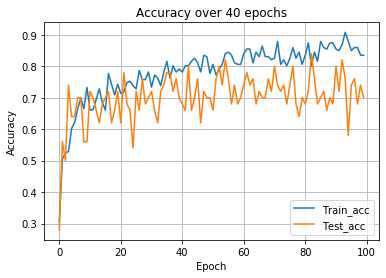

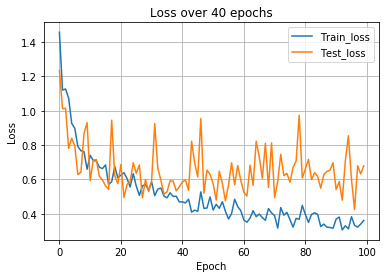

In [128]:
import matplotlib.pyplot as plt

#accuracy vs. epochs plot
plt.figure(1)
plt.plot(history.history['accuracy'], label='Train_acc')
plt.plot(history.history['val_accuracy'], label = 'Test_acc')
plt.title("Accuracy over 40 epochs")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.grid()

#loss vs. epochs plot
plt.figure(2)
plt.plot(history.history['loss'], label='Train_loss')
plt.plot(history.history['val_loss'], label = 'Test_loss')
plt.title("Loss over 40 epochs")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.grid()

plt.show()

#### Testing Model

In [129]:
model = covid_model
test_datagen = ImageDataGenerator(rescale=1. / 255)
#model.save_weights('./checkpoints/my_checkpoint')
#model.save('saved_model/my_model') 
eval_generator = test_datagen.flow_from_directory(TEST_DIR,target_size=IMAGE_SIZE,
                                                  batch_size=1,shuffle=False,seed=42,class_mode="categorical")
eval_generator.reset()
print(len(eval_generator))
x = model.evaluate_generator(eval_generator,steps = np.ceil(len(eval_generator)),
                           use_multiprocessing = False,verbose = 1,workers=1)
print('Test loss:' , x[0])
print('Test accuracy:',x[1])

Found 36 images belonging to 4 classes.
36
  ...
    to  
  ['...']
36/36 [==============================] - 1s 32ms/step - loss: 0.6274 - accuracy: 0.7778
Test loss: 0.6273693983481728
Test accuracy: 0.7777778


## [10 points] TSNE Plot
t-Distributed Stochastic Neighbor Embedding (t-SNE) is a widely used technique for dimensionality reduction that is particularly well suited for the visualization of high-dimensional datasets. After training is complete, extract features from a specific deep layer of your choice, use t-SNE to reduce the dimensionality of your extracted features to 2 dimensions and plot the resulting 2D features.

Found 270 images belonging to 4 classes.
{'covid': 0, 'normal': 1, 'pneumonia_bac': 2, 'pneumonia_vir': 3}


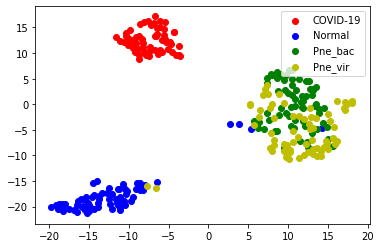

In [130]:
from sklearn.manifold import TSNE
from tensorflow.keras import models

intermediate_layer_model = models.Model(inputs=model.input,
                                        outputs=model.get_layer('feature_dense').output)

tsne_eval_generator = test_datagen.flow_from_directory(DATASET_PATH,target_size=IMAGE_SIZE,
                                                  batch_size=1,shuffle=False,seed=42,class_mode="categorical")

print(tsne_eval_generator.class_indices)
labels = tsne_eval_generator.labels

predict = intermediate_layer_model.predict_generator(tsne_eval_generator)

tsne = TSNE(n_components=2).fit_transform(predict)
covid = []
normal = []
pne_bac = []
pne_vir = []
for i in range(len(labels)):
    if labels[i]==0:
        covid.append(tsne[i])
    elif labels[i]==1:
        normal.append(tsne[i])
    elif labels[i]==2:
        pne_bac.append(tsne[i])
    else:
        pne_vir.append(tsne[i])
        
covid = np.asarray(covid)
normal = np.asarray(normal)
pne_bac = np.asarray(pne_bac)
pne_vir = np.asarray(pne_vir)


plt.scatter(covid[:,0],covid[:,1],c="r",label="COVID-19")
plt.scatter(normal[:,0],normal[:,1],c="b",label="Normal")
plt.scatter(pne_bac[:,0],pne_bac[:,1],c="g",label="Pne_bac")
plt.scatter(pne_vir[:,0],pne_vir[:,1],c="y",label="Pne_vir")
plt.legend(loc='upper right')
plt.show()

<!-- ## Task 2: COVID-19 vs Normal vs Tertiary Pneumonia (Bacterial and Viral) -->

<!-- #### Renew Training Batch and Validation Batch -->

<!-- #### Renew Model -->